gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

!pip install cellpose

from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

In [1]:
# Import modules
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from cellpose import models
from cellpose.io import imread
from cellpose import plot
from skimage.util import img_as_ubyte
import pandas as pd

In [2]:
import scipy

In [3]:
#------------------------------------------------------
# Number of images we want to read. Only in test phase. If we want to read all images we will use len(Cherry_file) in for loop below
nb_images = 1

# Get path to folders containing images
Image_Directory = os.getcwd() + "\\20151218_E14_BM_mTF8additionals_4"
#Image_Directory = r"C:\Users\alexi\EPFL\MA3\Machine_learning\20151218_E14_BM_mTF8additionals_4"  #Easier for me (Alexis) than finding of to get my path file nicely
#Image_Directory = "/content/gdrive/MyDrive/ML_2_transcripted_cherry/TF1"
# other folders: 
# \\20151218_E14_BM_mTF8additionals_4
# "//20151125_BM_mTF8additionals_3//Composite_mBM-mTF8"
print(Image_Directory)

# Calculate number of document-> array containing 


# Create Lists containing datapath to all images of Cherry/ Ypet files
image_format = "tif"
cherry_condition = "TexasRed"
ypet_condition = "YFP"
Cherry_file = []
Ypet_file = []
test = []

# Walk through directory (call all files) and assign them to proper list
for root, dirs, files in os.walk(Image_Directory, topdown=False): # root = given in Input, dirs = folders, files= files
    for f in files:
        if f.endswith(image_format) and cherry_condition in f: 
            test.append(f)
            Cherry_file.append(os.path.join(root, f))
        elif f.endswith(image_format) and ypet_condition in f: 
            Ypet_file.append(os.path.join(root, f))

assert len(Cherry_file) != len(Ypet_file), f"There are {len(Cherry_file)} Cherry files and {len(Ypet_file)} Ypet files. The number has to be equal, check manually what's missing"


# Initialize lists containing cherry, ypet images. Length = nb_images or len(Cherry_file) if we want to read all images
cherry_imgs = np.ndarray(nb_images,dtype = np.ndarray)
ypet_imgs = np.ndarray(nb_images,dtype = np.ndarray)


# Read image (We donnot add it in for loop above to enable reading subset of image)
for i in range(nb_images): #len(Cherry_file):
    cherry_imgs[i] = imread(Cherry_file[i])
    ypet_imgs[i] = imread(Ypet_file[i])
    
cherry_imgs = cherry_imgs.tolist()
ypet_imgs = ypet_imgs.tolist()

C:\Users\Sophia\Documents\EPFL\3rd_semester\Machine learning\project\P2\20151218_E14_BM_mTF8additionals_4


In [4]:
# Definine parameters for cellpose module using nuclei modus
# https://cellpose.readthedocs.io/en/latest/settings.html
channels = [0,0] # Corresponds to greyscale image
diameter = None # Model was trained on diameters of 17 pixels. None-> automated estimation of the diameter. Can be changed by hand later
flow_threshold = 0.4 # maximum allowed error of the flows for each mask, default = 0.4
gpu = False
model_type='nuclei'

# Set model
model = models.Cellpose(gpu, model_type)

# Nuclei segmentation of all images within cherry_imgs list
masks, flows, styles, diams = model.eval(cherry_imgs, diameter=diameter, channels=channels, flow_threshold=flow_threshold, do_3D=False)


In [5]:
'''
from cellpose import io
import os
#os.mkdir("/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1")
files_names = ["/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/img_"+str(i+1) for i in range(nb_images)]
io.masks_flows_to_seg(cherry_imgs, masks, flows, diams, files_names, channels)'''

'\nfrom cellpose import io\nimport os\n#os.mkdir("/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1")\nfiles_names = ["/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/img_"+str(i+1) for i in range(nb_images)]\nio.masks_flows_to_seg(cherry_imgs, masks, flows, diams, files_names, channels)'

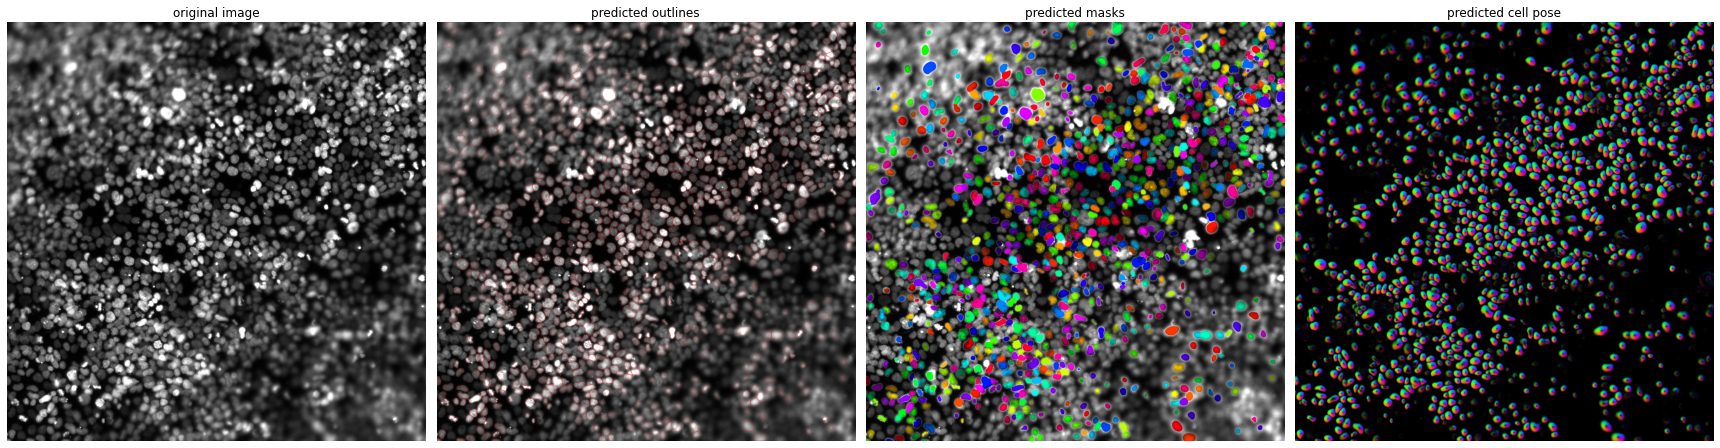

In [6]:
# Display results
image_i = 0 # Number of image we want to display. Max value= nb_images or len(Cherry_file)
fig = plt.figure(figsize=(24,8))
plot.show_segmentation(fig, cherry_imgs[image_i], masks[image_i], flows[image_i][0], channels)
plt.tight_layout()
plt.show()

***
Sophia explore

In [115]:
a = np.array([[0,0,0,0,2,2,8,2],[7,1,1,1,5,2,1,0],[0,0,0,1,2,3,4,9]])
a

array([[0, 0, 0, 0, 2, 2, 8, 2],
       [7, 1, 1, 1, 5, 2, 1, 0],
       [0, 0, 0, 1, 2, 3, 4, 9]])

In [118]:
boolean = np.where(a==3, 1,False) # Boolean matrix where patch = true
boolean
patch_boolean = a*boolean
patch_boolean

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0]])

In [119]:
drop_column = []
drop_nucleus = False
for column in range(boolean.shape[1]):
    if (((column == 0) | (column == boolean.shape[1]-1)) & (np.any(boolean[:,column])== True)):
        drop_nucleus = True
    if np.any(boolean[:,column])== False: #only backround values -> we can take this column out
        drop_column.append(column)
patch_data = np.delete(patch_boolean,drop_column,1)  
patch_data, drop_nucleus

drop_row = []
for row in range(boolean.shape[0]):
    if (((row == 0) | (row == boolean.shape[0]-1)) & (np.any(boolean[row,:])== True)):
        drop_nucleus = True
    if np.any(boolean[row,:])== False: #only backround values -> we can take this row out
        drop_row.append(row)
patch_data = np.delete(patch_data,drop_row,0)  
patch_data, drop_nucleus

(array([[3]]), True)

In [ ]:
drop_column = []
drop_nucleus = False
for column in range(boolean.shape[1]):
    if (((column == 0) | (column == boolean.shape[1]-1)) & (np.any(boolean[:,column])== True)):
        drop_nucleus = True
    if np.any(boolean[:,column])== False: #only backround values -> we can take this column out
        drop_column.append(column)
patch_data = np.delete(patch_boolean,drop_column,1)  
patch_data, drop_nucleus

drop_row = []
for row in range(boolean.shape[0]):
    if (((row == 0) | (row == boolean.shape[0]-1)) & (np.any(boolean[row,:])== True)):
        drop_nucleus = True
    if np.any(boolean[row,:])== False: #only backround values -> we can take this row out
        drop_row.append(row)
patch_data = np.delete(patch_data,drop_row,0)  
patch_data, drop_nucleus

In [ ]:
drop_nucleis = False # Drop if nucleus is by the border
drop_column = []

for column in range(boolean.shape[1]):
    if column == 0 | np.any(boolean[:,column])== True: # Check if nucleus is by the border

    if np.any(boolean[:,column])== False: #only backround values -> we can take this column out
        drop_column.append(column)
patch_data = np.delete(patch_boolean,drop_column,1)  

drop_row = []
for row in range(boolean.shape[0]):
    if np.any(boolean[row,:])== False: #only backround values -> we can take this row out
        drop_row.append(row)
patch_data = np.delete(patch_data,drop_row,0)  

Manually find right gabor filter settings: <br>
Nucleus is around 40 pixels -> kernel should be 1/2, 1/4 size<br>


In [155]:
import cv2

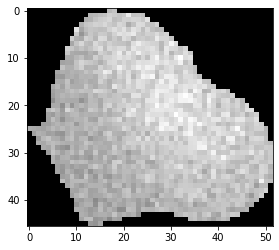

In [274]:
plt.imshow(patch_data, cmap='gray')

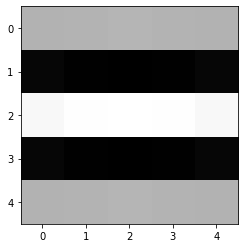

In [275]:
kernel = cv2.getGaborKernel((5,5), 3, np.pi*0.5, np.pi *0.75, 0.5, 0, ktype = cv2.CV_32F)
plt.imshow(kernel, cmap='gray')

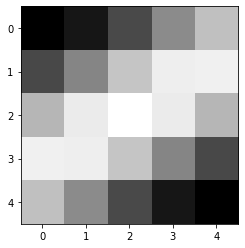

In [256]:
sigmas = [1,3]
tilts = [0,0.25,0.5,0.75] # perpendicular, diagonal, horizontal, other diagonal 
Wavelengths = [0,0.25,0.5,0.75] 
for tilt in tilts:
    for sigma in sigmas:
        for lambd in Wavelengths:
            kernel = cv2.getGaborKernel((5,5), sigma, tilt, lambd, 0.5, 0, ktype = cv2.CV_32F)
            plt.imshow(kernel, cmap='gray')

In [213]:
a = [1,3]
for i in a:
    print(i)

1
3


TypeError: 'int' object is not iterable

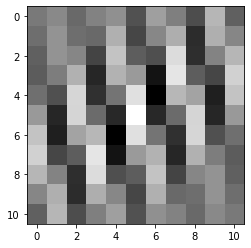

In [209]:
# prepare Gabor filter bank kernels
kernels = []

ksize = 10
sigma = [1,3]
n_theta = 3
gamma = 0.5
phi = 0
lambd = 1*np.pi/4


for theta in (4,4): #range(n_theta): # Direction
    theta = 1*np.pi / n_theta  
    for sigma in sigma: # size, large sigma might miss small features
        kernel = cv2.getGaborKernel((ksize,ksize), sigma, theta,lambd, gamma, phi, ktype = cv2.CV_32F)
        plt.imshow(kernel, cmap='gray')
        kernels.append(kernel)

image = patch_data
feats = np.zeros((len(kernels), 2), dtype=np.double)
plt.figure()
for k, kernel in enumerate(kernels):
    filtered = ndi.convolve(image, kernel, mode='wrap')
    plt.figure()
    plt.imshow(kernel, cmap='gray')

***

In [7]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
# https://stackoverflow.com/questions/19970764/making-feature-vector-from-gabor-filters-for-classification
# https://stackoverflow.com/questions/20608458/gabor-feature-extraction

In [285]:
b= np.array([1,2,3,4,5,6,7,20,21,22,23,24])
b

array([ 1,  2,  3,  4,  5,  6,  7, 20, 21, 22, 23, 24])

In [8]:
# prepare Gabor filter bank kernels
kernels = []
n_theta = 5 # The orientation of the normal to the parallel stripes of Gabor function

kernels = []
for theta in range(n_theta):
    theta = theta / n_theta * np.pi
    for sigma in (1, 3): 
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

In [ ]:
# Initialize list of features 
columnname = ["" for i in range(1)]
patch_size = [0 for i in range(1)]
mean_intensity = [0 for i in range(1)]
sum_intensity = [0 for i in range(1)]
median_intensity = [0 for i in range(1)]
variance_intensity = [0 for i in range(1)]
imgs = [-1 for i in range(1)]

step 0 over 1 is done!


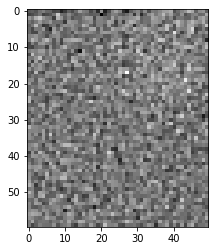

In [278]:
# Extract feature of each nucleus within images nb_images
for j in range(nb_images):
    mask =  masks[j]   
    ypet = ypet_imgs[j]
    range_s =  range(len(np.unique(mask)))  #IMAGE SPECIFIC: cases where cell are big enough (sell last cell of the notebook)
    columnname = ["" for i in range_s]
    patch_size = [0 for i in range_s]
    mean_intensity = [0 for i in range_s]
    sum_intensity = [0 for i in range_s]
    median_intensity = [0 for i in range_s]

    std_intensity = [0 for i in range_s]
    var_intensity = [0 for i in range_s]
    skew_intesity = [0 for i in range_s]
    kurt_intesity = [0 for i in range_s]
    iqr_intesity = [0 for i in range_s]
    entropy_intesity = [0 for i in range_s]
    
    imgs = [j for i in range_s]
    iter_i = 0 # Ensures that no 0 are saved where patch is too small/big
    
    # Iterate through all nucleus: Take submatrix, Calculate patch size and corresponding ypet signal (mean) and store it into ypet_intensity
    for i in range(4):#range_s : 
        cur = ypet[mask==i]
        patch_size_ = np.count_nonzero(~np.isnan(cur))
        
        # Extract submatrix with only patch in correct geometry to extract texture feature
        boolean = np.where(mask==i, 1,False) # Boolean matrix where patch = 1, else 0
        patch_boolean = ypet*boolean
        
        drop_column = []
        drop_variance_col1 = [] # all empy columns left of nucleus
        
        drop_nucleus = False # If true then nucleus is at the border
        drop_threshold = False # If variance is below threshhowld -> blurred-> take nucleus out. Variance of not yet not patchdata, which includes border
        
        
        for column in range(boolean.shape[1]):
            # drop nucleus if it's on the border 
            if (((column == 0) | (column == boolean.shape[1]-1)) & (np.any(boolean[:,column])== True)):
                drop_nucleus = True
            # drop nucleus if it only has 0 values (Mask)
            if np.any(boolean[:,column])== False: #only backround values -> we can take this column out
                if column = drop_column[-1]+1:
                    drop_variance_1 = drop_variance_col1.append(column)
                drop_column.append(column)
                
        patch_data = np.delete(patch_boolean,drop_column,1)  
        patch_variance = np.delete(ypet, drop_column[:,-5],1) 

        drop_row = []
        for row in range(boolean.shape[0]):
            if (((row == 0) | (row == boolean.shape[0]-1)) & (np.any(boolean[row,:])== True)):
                drop_nucleus = True
            if np.any(boolean[row,:])== False: #only backround values -> we can take this row out
                drop_row.append(row)
        patch_data = np.delete(patch_data,drop_row,0)  
        patch_variance = np.delete(patch_variance, drop_row,0)  
        
        plt.imshow(patch_variance, cmap='gray')
        
        
        if ((patch_size_ > 10) & (patch_size_ < 50000) & (drop_nucleus== False)): 
            
            # extract intensity feature
            columnname[iter_i] = "patch_" + str(iter_i)    #We should not forgot that there is a -1 here. (when it is here)               
            patch_size[iter_i] = patch_size_
            sum_intensity[iter_i] = np.sum(np.sum(cur))
            mean_intensity[iter_i] = np.nanmean(cur)
            median_intensity[iter_i] = np.nanmedian(cur)
            
            std_intensity[iter_i] = np.nanstd(cur)
            var_intensity[iter_i] = np.nanvar(cur)
            skew_intesity[iter_i] = scipy.stats.skew(cur)
            kurt_intesity[iter_i] = scipy.stats.kurtosis(cur)
            iqr_intesity[iter_i] = scipy.stats.iqr(cur)
            entropy_intesity[iter_i] = scipy.stats.entropy(cur)
            
            
            gabor = compute_feats(patch_data, kernels)
            
            iter_i +=1
    
    # Drop empty rows: some patches values were not calculated because their size is too small/big 
    if iter_i != range_s: # Some patches were not considered -> we have to drop those rows
        mean_intensity = mean_intensity[:iter_i]
        columnname = columnname[:iter_i]
        patch_size = patch_size[:iter_i]
        sum_intensity = sum_intensity[:iter_i]
        median_intensity = median_intensity[:iter_i]
        imgs = imgs[:iter_i]
        
        std_intensity = std_intensity[:iter_i] 
        var_intensity = var_intensity[:iter_i] 
        skew_intesity = skew_intesity[:iter_i] 
        kurt_intesity = kurt_intesity[:iter_i] 
        iqr_intesity = iqr_intesity[:iter_i]
        entropy_intesity = entropy_intesity[:iter_i] 
        
        
    ypet_intensity = pd.DataFrame(index=columnname)
    ypet_intensity['img'] = imgs
    ypet_intensity['patch_size'] = patch_size
    ypet_intensity['mean_intensity'] = mean_intensity
    ypet_intensity['sum_intensity'] = sum_intensity
    ypet_intensity['median_intensity'] = median_intensity
    
    ypet_intensity['standard_deviation'] = std_intensity 
    ypet_intensity['variance'] = var_intensity
    ypet_intensity['skewness'] = skew_intesity
    ypet_intensity['kurtosis'] = kurt_intesity
    ypet_intensity['interquartile_range ']= iqr_intesity
    ypet_intensity['entropy'] = entropy_intesity
   
    #ypet_intensity_glob = pd.concat([ypet_intensity_glob,ypet_intensity])
    print("step "+str(j)+" over "+str(nb_images)+ " is done!")
    

In [268]:
ypet_intensity

,img,patch_size,mean_intensity,sum_intensity,median_intensity,standard_deviation,variance,skewness,kurtosis,interquartile_range,entropy
patch_0,0,1442,888.985437,1281917,889.0,62.750230,3937.591327,0.063368,-0.132107,86.0,7.271293
patch_1,0,1597,1002.777708,1601436,1003.0,112.330691,12618.184149,0.094279,-0.409078,160.0,7.369596


In [ ]:
path = '/content/drive/MyDrive/Project_2_ml/20151218_E14_BM_mTF8additionals_4/Features/features_cells_TF8_A1.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
    ypet_intensity_glob.to_csv(f)


In [19]:
"""  Was just to create the ~800 folders easier :)
import os
alphabet = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
for k in range(8):
  for j in range(8):
    for i in range(12):
      os.mkdir("/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF"+str(k+1)+"/"+alphabet[j]+"_"+str(i+1))
"""

''' to remove the "copie" part of it once I did copy
import os
os.rename("/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/Copie de img_1_seg.npy","/content/gdrive/MyDrive/ML_2_transcripted_cherry/masks_TF1/A_1/img_1_seg.npy")
'''
